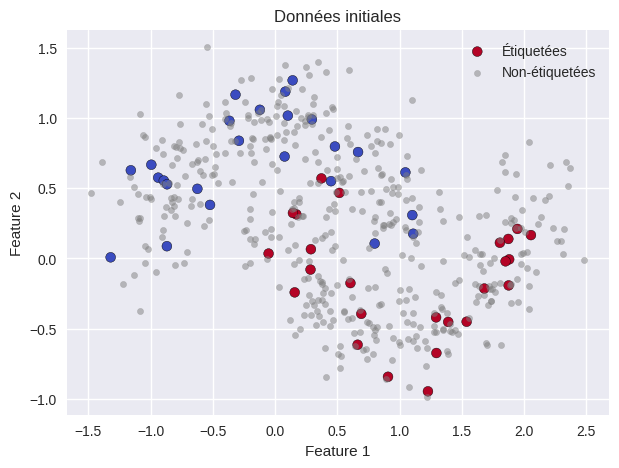

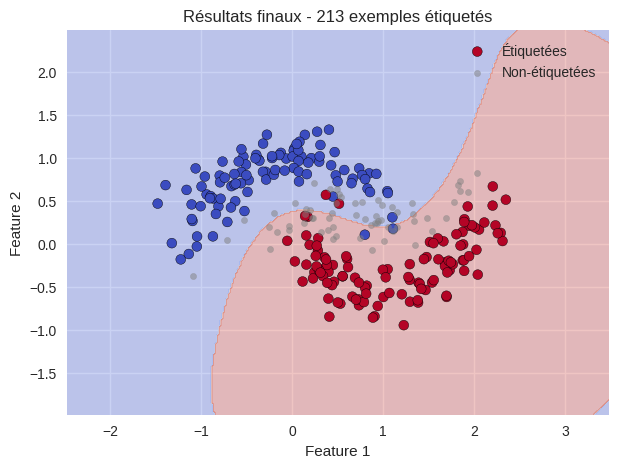

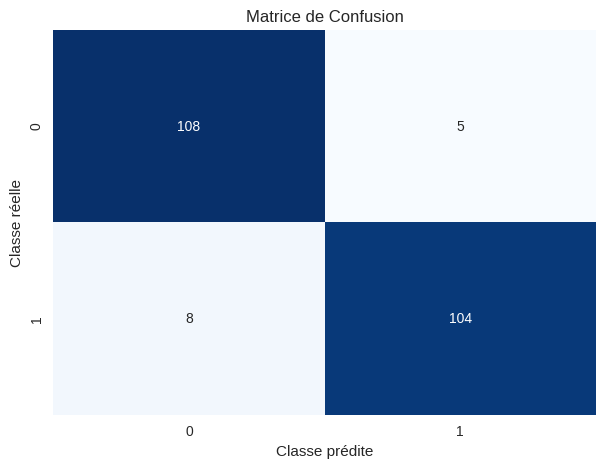

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import datasets
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
import seaborn as sns

# Configuration pour les graphiques
plt.style.use('seaborn-v0_8')
plt.rcParams['figure.figsize'] = (7, 5)

# Fonction de grille  -> pour la visualisation
def make_meshgrid(x, y, h=.02):
    x_min, x_max = x.min() - 1, x.max() + 1
    y_min, y_max = y.min() - 1, y.max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    return xx, yy

# Fonction pour tracer les frontières de décision
def plot_contours(ax, clf, xx, yy, **params):
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    out = ax.contourf(xx, yy, Z, **params)
    return out

# Fonction pour vérifier la consistance
def check_consistency(model, sample, pseudo_label, noise_level=0.1, num_perturbations=10, threshold=0.8):
    perturbed_samples = [sample + np.random.normal(0, noise_level, sample.shape) for _ in range(num_perturbations)]
    perturbed_preds = model.predict(np.array(perturbed_samples))
    consistency_ratio = np.mean(perturbed_preds == pseudo_label)
    return consistency_ratio >= threshold, consistency_ratio

# Ici on génére des données
X, y = datasets.make_moons(n_samples=500, noise=0.2, random_state=42)

# Séparation
X_train, X_unlabeled, y_train, y_unlabeled = train_test_split(X, y, test_size=0.9, random_state=42, stratify=y)
X_val, X_test, y_val, y_test = train_test_split(X_unlabeled, y_unlabeled, test_size=0.5, random_state=42, stratify=y_unlabeled)

# Visualiser les données d'origine (étiquetées vs non-étiquetées)
fig, ax = plt.subplots(figsize=(7, 5))
ax.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap=plt.cm.coolwarm, s=50, edgecolors='k', label='Étiquetées')
ax.scatter(X_unlabeled[:, 0], X_unlabeled[:, 1], c='gray', s=20, alpha=0.5, label='Non-étiquetées')
ax.set_title("Données initiales")
ax.set_xlabel("Feature 1")
ax.set_ylabel("Feature 2")
ax.legend()
plt.savefig("initial_data.png", dpi=300)
plt.show()

# Paramètres pour l'apprentissage semi-supervisé
confidence_threshold = 0.95
consistency_threshold = 0.8
max_iterations = 10
noise_level = 0.1
num_perturbations = 10

# Modèle SVM initial
svm = SVC(probability=True, kernel='rbf', gamma='scale', random_state=42)
svm.fit(X_train, y_train)

# Itérations d'auto-étiquetage avec vérification de consistance
for iteration in range(max_iterations):
    # Obtenir les probabilités pour les données non étiquetées
    probs = svm.predict_proba(X_val)
    pseudo_labels = np.argmax(probs, axis=1)
    confidence = np.max(probs, axis=1)

    # Sélectionner les échantillons avec confiance élevée
    confidence_mask = confidence > confidence_threshold

    # Vérifier la consistance
    consistent_mask = np.zeros_like(confidence_mask, dtype=bool)
    for i in np.where(confidence_mask)[0]:
        is_consistent, _ = check_consistency(svm, X_val[i], pseudo_labels[i],
                                          noise_level=noise_level,
                                          num_perturbations=num_perturbations,
                                          threshold=consistency_threshold)
        consistent_mask[i] = is_consistent

    # Combiner les deux critères
    final_mask = confidence_mask & consistent_mask

    # Si aucun exemple n'est ajouté, arrêter
    if not np.any(final_mask):
        break

    # Ajouter ces données aux données étiquetées
    X_train = np.vstack((X_train, X_val[final_mask]))
    y_train = np.hstack((y_train, pseudo_labels[final_mask]))

    # Retirer les nouvelles données de X_val
    X_val = X_val[~final_mask]
    y_val = y_val[~final_mask]

    # Ré-entraîner le modèle
    svm.fit(X_train, y_train)

# Visualiser les résultats finaux
fig, ax = plt.subplots(figsize=(7, 5))
xx, yy = make_meshgrid(X[:, 0], X[:, 1])
plot_contours(ax, svm, xx, yy, cmap=plt.cm.coolwarm, alpha=0.3)
ax.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap=plt.cm.coolwarm, s=50, edgecolors='k', label='Étiquetées')
if len(X_val) > 0:
    ax.scatter(X_val[:, 0], X_val[:, 1], c='gray', s=20, alpha=0.5, label='Non-étiquetées')
ax.set_title(f"Résultats finaux - {len(X_train)} exemples étiquetés")
ax.set_xlabel("Feature 1")
ax.set_ylabel("Feature 2")
ax.legend()
plt.savefig("final_results.png", dpi=300)
plt.show()

# Visualiser la matrice de confusion
cm = confusion_matrix(y_test, svm.predict(X_test))
fig, ax = plt.subplots(figsize=(7, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False, ax=ax)
ax.set_xlabel('Classe prédite')
ax.set_ylabel('Classe réelle')
ax.set_title("Matrice de Confusion")
plt.savefig("confusion_matrix.png", dpi=300)
plt.show()